# Results Analysis for Benchmark Script 

In [1]:
%matplotlib inline 

In [2]:
import os 
import re
import csv 
import glob

import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 

from datetime import datetime 
from collections import defaultdict

In [3]:
sns.set_style('whitegrid')
sns.set_context('notebook')
sns.set_palette('muted')

In [4]:
DTFMT = "%Y%m%d%H%M"
FIXTURES = os.path.join(os.getcwd(), "..", "fixtures")

def get_latest_results(path=FIXTURES):
    results = None 
    latest  = None
    
    for name in glob.glob(os.path.join(path, "results-*.csv")):
        base = os.path.basename(name)
        fname, ext = os.path.splitext(base)
        rdate = datetime.strptime(fname.split("-")[1], DTFMT)
    
        if latest is None or rdate > latest:
            latest  = rdate 
            results = name 
    
    if results is None:
        raise ValueError("could not find results file")
    
    return pd.read_csv(name), latest 
        
        
results, rdate = get_latest_results()    

In [5]:
results.head()

,test name,test path,clone time,build time,clone stat,clone bytes,clone files,clone dirs,build stat,build bytes,build files,build dirs
0,redis,disk,13.554977,25.659183,0.008584,79727295,657,76,0.009509,87936076,782,76
1,nginx,disk,8.112083,28.807794,0.006721,63260422,467,63,0.009877,69135205,591,78
2,redis,memfs,192.157993,29.561390,0.133694,79727295,657,76,0.113503,87936380,782,76
3,nginx,memfs,124.993079,37.982397,0.079341,63260422,467,63,0.116400,69135449,591,78


In [6]:
results.rename(columns={'test path': 'file system'}, inplace=True)

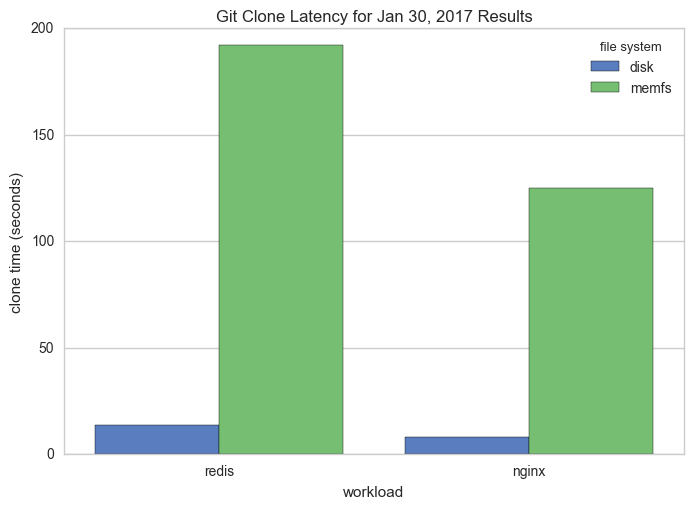

In [7]:
sns.barplot(x='test name', y='clone time', hue='file system', data=results)
plt.xlabel('workload')
plt.ylabel('clone time (seconds)')
plt.title('Git Clone Latency for {} Results'.format(rdate.strftime('%b %d, %Y')))
plt.savefig('{}-clone-time.png'.format(rdate.strftime('%Y-%m-%d')))

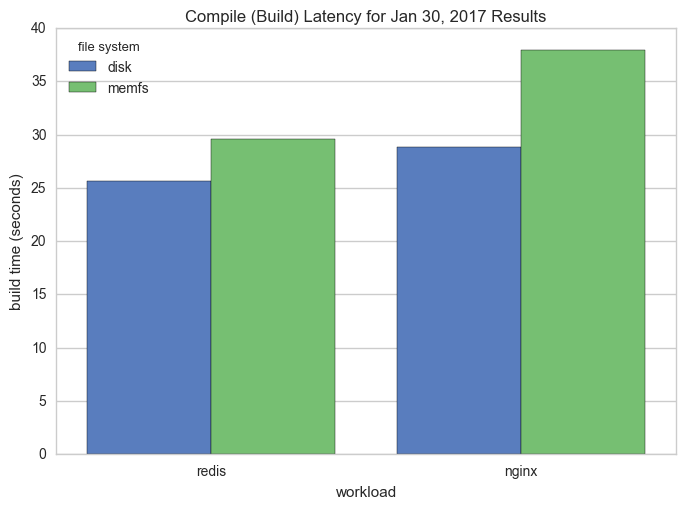

In [8]:
sns.barplot(x='test name', y='build time', hue='file system', data=results)
plt.xlabel('workload')
plt.ylabel('build time (seconds)')
plt.title('Compile (Build) Latency for {} Results'.format(rdate.strftime('%b %d, %Y')))
plt.savefig('{}-build-time.png'.format(rdate.strftime('%Y-%m-%d')))

In [9]:
MPROF_FIXTURES = os.path.join(FIXTURES, "mprof")

cmdre = re.compile(r"^CMDLINE\s+(.+)$")
memre = re.compile(r"^MEM\s+([\d\.e]+)\s+([\d\.e]+)$")


def get_mprofile_results(path=MPROF_FIXTURES):
    series = defaultdict(list)
    
    for name in glob.glob(os.path.join(path, 'mprofile_*.dat')):
        base = os.path.basename(name)
        fname, ext = os.path.splitext(base) 
        test = fname.split('_')[1]
        
        with open(name, 'r') as f:
            for line in f:
                match = memre.match(line)
                if match:
                    series[test].append(tuple(map(float, match.groups())))
        
        stime = series[test][0][1]
        for idx in range(len(series[test])):
            series[test][idx] = (series[test][idx][0], series[test][idx][1] - stime)
        
    return series 
        

def get_mprofile_baseline(path=MPROF_FIXTURES):
    base = {}
    with open(os.path.join(path, 'baseline.csv')) as f:
        reader = csv.DictReader(f) 
        for row in reader:
            base[row['test name']] = float(row['build bytes']) / 1048576.0 
    
    return base 
        
        
mprof = get_mprofile_results()
baseline = get_mprofile_baseline()

In [10]:
baseline

{'apache': 344.8736171722412,
 'nginx': 65.93246936798096,
 'python': 414.98586559295654,
 'redis': 83.86237716674805,
 'ruby': 270.5074281692505}

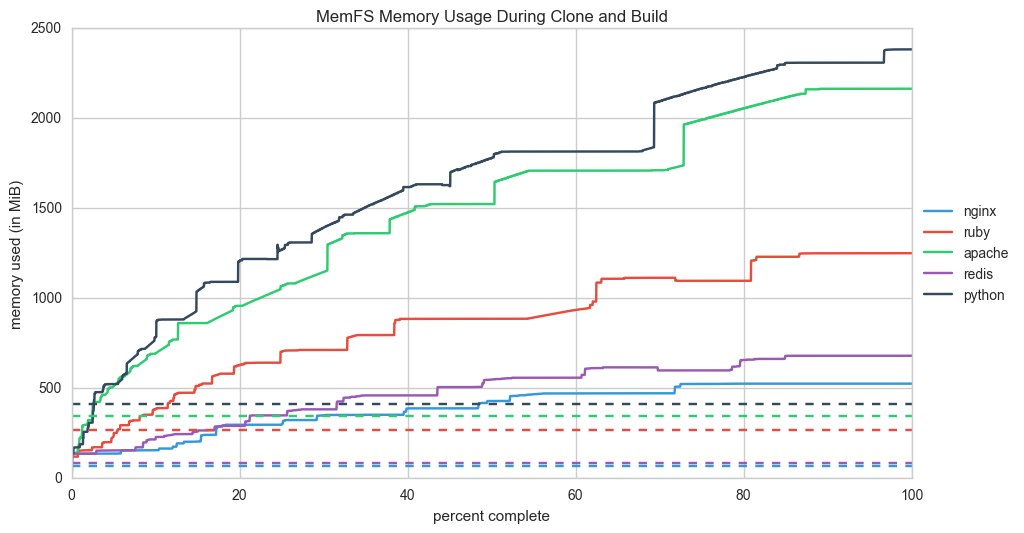

In [13]:
fig = plt.figure(figsize=(14,6))
axe = fig.add_axes([0.1, 0.1, 0.6, 0.75])
axe.set_xlabel("percent complete")
axe.set_ylabel("memory used (in MiB)")
axe.set_title("MemFS Memory Usage During Clone and Build")

colors = {
    'python': "#34495e",
    'apache': "#2ecc71",
    'ruby': "#e74c3c", 
    'redis': "#9b59b6", 
    'nginx': "#3498db", 
    'postgres': "#f4d03f", 
}

for name, data in mprof.items():
    ts = np.asarray([item[1] for item in data])
    ts = ts / ts.max() * 100.0
    mem = np.asarray([item[0] for item in data])
    plt.plot(ts, mem, "+-", c=colors[name], label=name)

for name, maxval in baseline.items():
    plt.plot([0, 100], [maxval, maxval], "--", c=colors[name])

legend = axe.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend.get_frame().set_alpha(0.5)

plt.savefig('{}-mprof-memfs.png'.format(rdate.strftime('%Y-%m-%d')))